In [1]:
%matplotlib widget
from util import get_path
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import generate_nx_graph, transform_list, generate_skeleton, generate_nx_graph_from_skeleton, from_connection_tab, from_nx_to_tab
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign, realign_final
from datetime import datetime,timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy,copy
from collections import Counter
import cv2 
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from extract_graph import dic_to_sparse, from_sparse_to_graph, generate_nx_graph, prune_graph, from_nx_to_tab, from_nx_to_tab_matlab,sparse_to_doc, connections_pixel_list_to_tab, transform_list, clean_degree_4
from time import sleep
from pycpd import RigidRegistration, DeformableRegistration
import open3d as o3d
from cycpd import rigid_registration

In [13]:
plate = 5
for j in range(0,7):
    my_file = open("/scratch/shared/mrozemul/Fiji.app/align.sh", "w")
    my_file.write("#!/bin/bash \n#Set job requirements \n#SBATCH -N 1 \n#SBATCH -t 2:00:00\n#SBATCH -p normal\n")
    my_file.write(f'for i in `seq {8*j} {8*j+7}`; do\n')
    my_file.write(f'\t python ~/Corentin/MscThesis/final_alignment.py $i {plate} &\n')
    my_file.write('done\n')
    my_file.write('wait\n')
    my_file.close()
# !srun -t 2:00:00 --pty /scratch/shared/mrozemul/Fiji.app/align.sh
    !sbatch /scratch/shared/mrozemul/Fiji.app/align.sh

Submitted batch job 9365975
Submitted batch job 9365976
Submitted batch job 9365977
Submitted batch job 9365978
Submitted batch job 9365979
Submitted batch job 9365980
Submitted batch job 9365981


In [12]:
plate = 3
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
len(list_dir_interest)

20

In [17]:
dates_datetime_chosen

[datetime.datetime(2020, 8, 14, 4, 57),
 datetime.datetime(2020, 8, 14, 8, 57),
 datetime.datetime(2020, 8, 14, 12, 57),
 datetime.datetime(2020, 8, 14, 16, 57),
 datetime.datetime(2020, 8, 14, 20, 57),
 datetime.datetime(2020, 8, 15, 0, 57),
 datetime.datetime(2020, 8, 15, 4, 57),
 datetime.datetime(2020, 8, 15, 8, 57),
 datetime.datetime(2020, 8, 15, 12, 57),
 datetime.datetime(2020, 8, 15, 16, 57),
 datetime.datetime(2020, 8, 15, 20, 57),
 datetime.datetime(2020, 8, 16, 0, 57),
 datetime.datetime(2020, 8, 16, 4, 57),
 datetime.datetime(2020, 8, 16, 8, 57),
 datetime.datetime(2020, 8, 16, 12, 57),
 datetime.datetime(2020, 8, 16, 16, 57),
 datetime.datetime(2020, 8, 16, 20, 57),
 datetime.datetime(2020, 8, 17, 0, 57),
 datetime.datetime(2020, 8, 17, 4, 57)]

In [16]:
plt.close('all')
plate = 11
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime[1:20]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
dilateds=[]
skels = []
skel_docs = []
Rs=[]
ts=[]
for date in dates:
    directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
    path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
    skel = skel_info['skeleton']
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
    transform = sio.loadmat(path_snap+'/Analysis/transform.mat')
    R,t = transform['R'],transform['t']
    Rs.append(R)
    ts.append(t)
for j in range(11,19): 
    skeleton1,skeleton2 = skel_docs[j-1],skel_docs[j]
    R,t = Rs[j],ts[j]
    skelet_pos = np.array(list(skeleton1.keys()))
    samples = np.random.choice(skelet_pos.shape[0],20000)
    X = np.transpose(skelet_pos[samples,:])
    skelet_pos = np.array(list(skeleton2.keys()))
    samples = np.random.choice(skelet_pos.shape[0],20000)
    Y = np.transpose(skelet_pos[samples,:])
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    Yrep=np.transpose(np.transpose(np.dot(R,X))+t)
    ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
#     ax.scatter(np.transpose(X)[:,0],np.transpose(X)[:,1])
    ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
plt.close('all')
plate = 3
directory = "/scratch/shared/mrozemul/Fiji.app/" 
listdir=os.listdir(directory) 
list_dir_interest=[name for name in listdir if name.split('_')[-1]==f'Plate{0 if plate<10 else ""}{plate}']
ss=[name.split('_')[0] for name in list_dir_interest]
ff=[name.split('_')[1] for name in list_dir_interest]
dates_datetime=[datetime(year=int(ss[i][:4]),month=int(ss[i][4:6]),day=int(ss[i][6:8]),hour=int(ff[i][0:2]),minute=int(ff[i][2:4])) for i in range(len(list_dir_interest))]
dates_datetime.sort()
dates_datetime_chosen=dates_datetime[23:28]
dates = [f'{0 if date.month<10 else ""}{date.month}{0 if date.day<10 else ""}{date.day}_{0 if date.hour<10 else ""}{date.hour}{0 if date.minute<10 else ""}{date.minute}' for date in dates_datetime_chosen]
dilateds=[]
skels = []
skel_docs = []
for date in dates:
    directory_name=f'2020{date}_Plate{0 if plate<10 else ""}{plate}'
    path_snap='/scratch/shared/mrozemul/Fiji.app/'+directory_name
    skel_info = read_mat(path_snap+'/Analysis/skeleton.mat')
    skel = skel_info['skeleton']
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
for j in range(2): 
    skeleton1,skeleton2 = skel_docs[j],skel_docs[j+1]
skelet_pos = np.array(list(skeleton1.keys()))
samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
X = np.transpose(skelet_pos[samples,:])
skelet_pos = np.array(list(skeleton2.keys()))
samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
Y = np.transpose(skelet_pos[samples,:])
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
dates_datetime_chosen

[datetime.datetime(2020, 7, 16, 11, 34), datetime.datetime(2020, 7, 18, 9, 25)]

In [11]:
len(skeleton2.keys())/100

13430.87

In [13]:
# skelet_pos = np.array(list(skeleton1.keys()))
# samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
# X = np.transpose(skelet_pos[samples,:])
# skelet_pos = np.array(list(skeleton2.keys()))
# samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
# Y = np.transpose(skelet_pos[samples,:])

In [16]:
skelet_pos = np.array(list(skeleton1.keys()))
samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
X = np.transpose(skelet_pos[samples,:])
skelet_pos = np.array(list(skeleton2.keys()))
samples = np.random.choice(skelet_pos.shape[0],len(skeleton2.keys())//100)
Y = np.transpose(skelet_pos[samples,:])

In [17]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
reg = rigid_registration(**{'X': np.transpose(X.astype(float)), 'Y': np.transpose(Y.astype(float)),'scale': False})
out = reg.register()
Rfound = reg.R[0:2,0:2]
tfound= np.dot(Rfound,reg.t[0:2])

Iteration:1
ML:156884.936; 	ML change (error):156884.936; 	Sigma^2:41312564.378; 	Sigma^2 change:93626448.824
[                                                                        ]
Iteration:2
ML:144516.661; 	ML change (error): 12368.275; 	Sigma^2:21057469.076; 	Sigma^2 change:20255095.302
[=                                                                       ]
Iteration:3
ML:139905.672; 	ML change (error):  4610.989; 	Sigma^2:13829033.633; 	Sigma^2 change:7228435.443
[==                                                                      ]
Iteration:4
ML:137780.776; 	ML change (error):  2124.896; 	Sigma^2:10018909.831; 	Sigma^2 change:3810123.802
[==                                                                      ]
Iteration:5
ML:136427.418; 	ML change (error):  1353.357; 	Sigma^2:7628076.916; 	Sigma^2 change:2390832.915
[===                                                                     ]
Iteration:6
ML:135416.149; 	ML change (error):  1011.269; 	Sigma^2:5985847.013;

In [20]:
plt.close('all')
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
Yrep=np.transpose(np.transpose(np.dot(Rfound,np.transpose(np.transpose(X))))-tfound)
ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])
ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [2]:
import matplotlib.pyplot as plt



In [11]:
%matplotlib widget
plt.close('all')
from util import get_path, get_dates_datetime, get_dirname
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from extract_graph import (
    generate_nx_graph,
    transform_list,
    generate_skeleton,
    generate_nx_graph_from_skeleton,
    from_connection_tab,
    from_nx_to_tab,
)
from node_id import whole_movement_identification, second_identification
import ast
from plotutil import plot_t_tp1, compress_skeleton
from scipy import sparse
from sparse_util import dilate, zhangSuen
from realign import realign, realign_final
from datetime import datetime, timedelta
from node_id import orient
import pickle
from matplotlib.widgets import CheckButtons
import scipy.io as sio
import imageio
from pymatreader import read_mat
from matplotlib import colors
from copy import deepcopy, copy
from collections import Counter
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage.morphology import thin
from skimage import data, filters
from random import choice
import scipy.sparse
import os
from time import time
from extract_graph import (
    dic_to_sparse,
    from_sparse_to_graph,
    generate_nx_graph,
    prune_graph,
    from_nx_to_tab,
    from_nx_to_tab_matlab,
    sparse_to_doc,
    connections_pixel_list_to_tab,
    transform_list,
    clean_degree_4,
    get_degree3_nodes,
)
from time import sleep
from pycpd import RigidRegistration, DeformableRegistration
import open3d as o3d
from cycpd import rigid_registration
import sys

plt.close('all')

i = 23
plate = 40

from directory import directory

dates_datetime = get_dates_datetime(directory,plate)
dates_datetime.sort()
dates_datetime_chosen = dates_datetime[i : i + 2]
print("========")
print(f"Matching plate {plate} at dates {dates_datetime_chosen}")
print("========")
dates = dates_datetime_chosen

dilateds = []
skels = []
skel_docs = []
for date in dates:
    directory_name = get_dirname(date, plate)
    path_snap = directory + directory_name
    skel_info = read_mat(path_snap + "/Analysis/skeleton_pruned.mat")
    skel = skel_info["skeleton"]
    skels.append(skel)
    skel_doc = sparse_to_doc(skel)
    skel_docs.append(skel_doc)
isnan = True
while isnan:
    isnan = False
    skeleton1, skeleton2 = skel_docs[0], skel_docs[1]
    skelet_pos = np.array(list(skeleton1.keys()))
    samples = np.random.choice(skelet_pos.shape[0], len(skeleton2.keys()) // 100)
    X = np.transpose(skelet_pos[samples, :])
    skelet_pos = np.array(list(skeleton2.keys()))
    samples = np.random.choice(skelet_pos.shape[0], len(skeleton2.keys()) // 100)
    Y = np.transpose(skelet_pos[samples, :])
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.scatter(X[0,:],X[1,:])
    ax.scatter(Y[0,:],Y[1,:])
    reg = rigid_registration(
        **{
            "X": np.transpose(X.astype(float)),
            "Y": np.transpose(Y.astype(float)),
            "scale": False,
        }
    )
    out = reg.register()
    Rfound = reg.R[0:2, 0:2]
    tfound = np.dot(Rfound, reg.t[0:2])
#     nx_graph1, pos1 = generate_nx_graph(from_sparse_to_graph(skeleton1))
#     nx_graph2, pos2 = generate_nx_graph(from_sparse_to_graph(skeleton2))
#     pruned1 = prune_graph(nx_graph1)
#     pruned2 = prune_graph(nx_graph2)
#     pruned1 = nx_graph1
#     pruned2 = nx_graph2
    t_init = -tfound
    Rot_init = Rfound
    isnan = np.isnan(tfound[0])
    if isnan:
        continue
#     X = np.transpose(
#         np.array([pos1[node] for node in pruned1 if pruned1.degree(node) == 3])
#     )
#     Y = np.transpose(
#         np.array([pos2[node] for node in pruned2 if pruned2.degree(node) == 3])
#     )
    X = np.transpose(
        np.array(get_degree3_nodes(skeleton1))
    )
    Y = np.transpose(
        np.array(get_degree3_nodes(skeleton2))
    )
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.scatter(X[0,:],X[1,:])
    ax.scatter(Y[0,:],Y[1,:])
    Xex = np.transpose(np.transpose(np.dot(Rot_init, X)) + t_init)
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.scatter(Xex[0,:],Xex[1,:])
    ax.scatter(Y[0,:],Y[1,:])
    X = np.insert(X, 2, values=0, axis=0)
    Y = np.insert(Y, 2, values=0, axis=0)
    print(X.shape, Y.shape)
    vectorX = o3d.utility.Vector3dVector(np.transpose(X))
    vectorY = o3d.utility.Vector3dVector(np.transpose(Y))
    source = o3d.geometry.PointCloud(vectorX)
    target = o3d.geometry.PointCloud(vectorY)
    threshold = 200
    trans_init = np.asarray(
        [
            [Rot_init[0, 0], Rot_init[0, 1], 0, t_init[0]],
            [Rot_init[1, 0], Rot_init[1, 1], 0, t_init[1]],
            [0, 0, 1, 0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    reg_p2p = o3d.registration.registration_icp(
        source,
        target,
        threshold,
        trans_init,
        o3d.registration.TransformationEstimationPointToPoint(),
    )
    print(reg_p2p)
    Rfound = reg_p2p.transformation[0:2, 0:2]
    tfound = reg_p2p.transformation[0:2, 3]
    print(Rfound, tfound)
    X, Y = X[0:2, :], Y[0:2, :]
    Yrep = np.transpose(np.transpose(np.dot(Rfound, X)) + tfound)
    fig=plt.figure(figsize=(10,9))
    ax = fig.add_subplot(111)
    ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
    ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

Matching plate 40 at dates [datetime.datetime(2020, 11, 23, 16, 4), datetime.datetime(2020, 11, 23, 20, 4)]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Iteration:1
ML: 60148.102; 	ML change (error): 60148.102; 	Sigma^2:33430884.823; 	Sigma^2 change:26258475.123
[                                                                        ]
Iteration:2
ML: 58892.492; 	ML change (error):  1255.610; 	Sigma^2:24289143.717; 	Sigma^2 change:9141741.107
[=                                                                       ]
Iteration:3
ML: 58442.557; 	ML change (error):   449.935; 	Sigma^2:19694577.279; 	Sigma^2 change:4594566.437
[==                                                                      ]
Iteration:4
ML: 58234.066; 	ML change (error):   208.491; 	Sigma^2:17020764.293; 	Sigma^2 change:2673812.986
[==                                                                      ]
Iteration:5
ML: 58128.775; 	ML change (error):   105.291; 	Sigma^2:15340576.101; 	Sigma^2 change:1680188.192
[===                                                                     ]
Iteration:6
ML: 58073.751; 	ML change (error):    55.024; 	Sigma^2:14234543.984

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(3, 2151) (3, 2229)
registration::RegistrationResult with fitness=2.352394e-01, inlier_rmse=1.213964e+02, and correspondence_set size of 506
Access transformation to get result.
[[ 0.99983864 -0.01796376]
 [ 0.01796376  0.99983864]] [ -114.41480777 -1213.20753343]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
reg.sigma2

In [7]:
skels[0].shape

(26322, 31000)

NameError: name 'X' is not defined

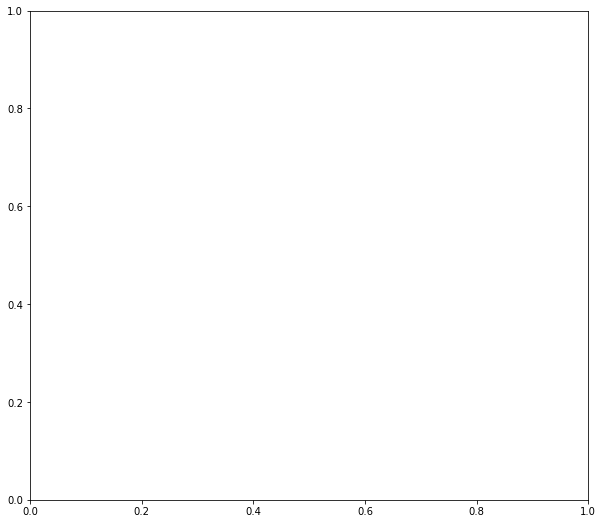

In [4]:
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])

In [13]:
help(reg)

Help on rigid_registration in module cycpd.rigid_registration object:

class rigid_registration(cycpd.expectation_maximization_registration.expectation_maximization_registration)
 |  rigid_registration(R=None, t=None, s=None, scale=True, *args, **kwargs)
 |  
 |  Method resolution order:
 |      rigid_registration
 |      cycpd.expectation_maximization_registration.expectation_maximization_registration
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, R=None, t=None, s=None, scale=True, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_registration_parameters(self)
 |  
 |  transform_point_cloud(self, Y=None)
 |  
 |  update_transform(self)
 |  
 |  update_variance(self)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from cycpd.expectation_maximization_registration.expectation_maximization_registration:
 |  
 |  expectation(self)
 |  
 |  iterate(self)


In [6]:
skelet_pos = np.array(list(skeleton1.keys()))
samples = np.random.choice(skelet_pos.shape[0], len(skeleton2.keys()) // 100)
X = np.transpose(skelet_pos[samples, :])
skelet_pos = np.array(list(skeleton2.keys()))
samples = np.random.choice(skelet_pos.shape[0], len(skeleton2.keys()) // 100)
Y = np.transpose(skelet_pos[samples, :])

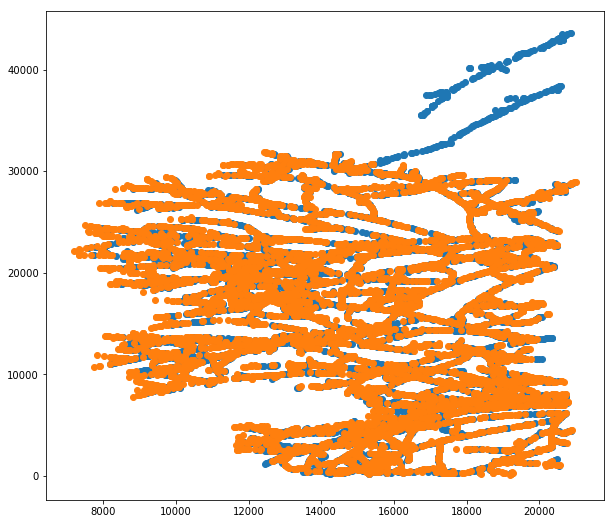

In [10]:
plt.close('all')
Xex = np.transpose(np.transpose(np.dot(Rot_init, X)) + t_init)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])

In [3]:
Y = np.transpose(
    np.array(get_degree3_nodes(skeleton2))
)

In [10]:
def get_neighbours(pixel,non_zero_pixel):
    x=pixel[0]
    y=pixel[1]
    primary_neighbours = {(x+1,y),(x-1,y),(x,y+1),(x,y-1)}
    secondary_neighbours = {(x+1,y-1),(x+1,y+1),(x-1,y+1),(x-1,y-1)}
    num_neighbours = 0
    actual_neighbours = []
    for neighbour in primary_neighbours:
        if neighbour in non_zero_pixel:
            num_neighbours +=1
            xp=neighbour[0]
            yp=neighbour[1]
            primary_neighboursp = {(xp+1,yp),(xp-1,yp),(xp,yp+1),(xp,yp-1)}
            for neighbourp in primary_neighboursp:
                secondary_neighbours.discard(neighbourp)
            actual_neighbours.append(neighbour)
    for neighbour in secondary_neighbours:
        if neighbour in non_zero_pixel:
            num_neighbours +=1
            actual_neighbours.append(neighbour)
    return(actual_neighbours,num_neighbours)

def get_degree3_nodes(skel):
    deg_3=[]
    non_zero= skel.keys()
    for pixel in non_zero:
        n, num = get_neighbours(pixel,non_zero)
        if num ==3:
            deg_3.append(pixel)
    return(deg_3)

In [21]:
nx_graph1,pos1 = generate_nx_graph(from_sparse_to_graph(skeleton1))
nx_graph2,pos2 = generate_nx_graph(from_sparse_to_graph(skeleton2))
pruned1 = prune_graph(nx_graph1)
pruned2 = prune_graph(nx_graph2)
t_init=-tfound
Rot_init= Rfound
X = np.transpose(np.array([pos1[node] for node in pruned1 if pruned1.degree(node)==3]))
Y = np.transpose(np.array([pos2[node] for node in pruned2 if pruned2.degree(node)==3]))
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(X[0,:],X[1,:])
ax.scatter(Y[0,:],Y[1,:])
Xex = np.transpose(np.transpose(np.dot(Rot_init,X))+t_init)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(Xex[0,:],Xex[1,:])
ax.scatter(Y[0,:],Y[1,:])
X = np.insert(X, 2, values=0, axis=0) 
Y = np.insert(Y, 2, values=0, axis=0) 
print(X.shape,Y.shape)
vectorX = o3d.utility.Vector3dVector(np.transpose(X))
vectorY = o3d.utility.Vector3dVector(np.transpose(Y))
source = o3d.geometry.PointCloud(vectorX)
target = o3d.geometry.PointCloud(vectorY)
threshold = 200
trans_init = np.asarray([[Rot_init[0,0], Rot_init[0,1], 0, t_init[0]],
                         [Rot_init[1,0], Rot_init[1,1], 0, t_init[1]],
                         [0, 0, 1, 0], [0.0, 0.0, 0.0, 1.0]])
reg_p2p = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
Rfound = reg_p2p.transformation[0:2,0:2]
tfound = reg_p2p.transformation[0:2,3]
print(Rfound,tfound)
X,Y=X[0:2,:],Y[0:2,:]
Yrep=np.transpose(np.transpose(np.dot(Rfound,X))+tfound)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

[18675.46806, 35.852915, 1.843764]
[21175.442981, 35.527758, 10.966272, 2.85076, 1.815892]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(3, 9932) (3, 11003)
registration::RegistrationResult with fitness=9.386830e-01, inlier_rmse=3.091225e+01, and correspondence_set size of 9323
Access transformation to get result.
[[ 0.99927149  0.03816407]
 [-0.03816407  0.99927149]] [-3804.48748894  3894.69968369]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
X = np.transpose(np.array([pos1[node] for node in pruned1 if pruned1.degree(node)==3]))
Y = np.transpose(np.array([pos2[node] for node in pruned2 if pruned2.degree(node)==3]))
Yrep=np.transpose(np.transpose(np.dot(Rfound,X))+tfound)
fig=plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
ax.scatter(np.transpose(Yrep)[:,0],np.transpose(Yrep)[:,1])
ax.scatter(np.transpose(Y)[:,0],np.transpose(Y)[:,1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [20]:
sio.savemat(path_snap+'/Analysis/transform.mat',{'R' : Rfound,'t' : tfound})